## Домашнее задание
1. Попробуйте обучить нейронную сеть RNN/LSTM/GRU на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). 

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [1]:
import pandas as pd
from keras.layers import SimpleRNN, LSTM, SimpleRNNCell, Dense
from keras.models import Sequential
import tensorflow as tf

In [2]:
!wget 'https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb' -O airline-passengers.csv

--2022-03-12 18:26:39--  https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb
Resolving drive.google.com (drive.google.com)... 173.194.203.100, 173.194.203.113, 173.194.203.139, ...
Connecting to drive.google.com (drive.google.com)|173.194.203.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/j8tb7em9p3ulj3sjfe92i6tm4lil8i4p/1647109575000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=download [following]
--2022-03-12 18:26:40--  https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/j8tb7em9p3ulj3sjfe92i6tm4lil8i4p/1647109575000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=download
Resolving doc-08-c0-docs.googleusercontent.com (doc-08-c0-docs.googleusercontent.com)... 74.125.199.132, 2607:f8b0:400e:c02::84
Connecting to doc-08-c0-docs.googleusercontent.com (doc-08-c0-

In [3]:
df = pd.read_csv('/content/airline-passengers.csv')
df

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


## Сделаем из даты несколько признаков

In [4]:
from datetime import date
from datetime import time
from datetime import datetime
import calendar

In [5]:
df['year'] = df['Month'].apply(lambda x: datetime.strptime(x, "%Y-%m").year)
df['month'] = df['Month'].apply(lambda x: datetime.strptime(x, "%Y-%m").month)
df['days_in_month'] = df['Month'].apply(lambda x: calendar.monthrange(datetime.strptime(x, "%Y-%m").year, datetime.strptime(x, "%Y-%m").month)[1])
df['Month'] = df['Month'].apply(lambda x: datetime.strptime(x, "%Y-%m"))
df['quarter'] = df['Month'].dt.quarter
df.drop(columns=['Month'], inplace=True)

In [6]:
df.head()

,Passengers,year,month,days_in_month,quarter
0,112,1949,1,31,1
1,118,1949,2,28,1
2,132,1949,3,31,1
3,129,1949,4,30,2
4,121,1949,5,31,2


## Разделим выборку на трейн и тест

In [7]:
train_size = 110


# отступ теста от тренировки
bias = 10


# делим
train_data = df.iloc[:train_size]
val_data = df.iloc[train_size + bias:]

train_data.shape, val_data.shape

((110, 5), (24, 5))

In [8]:
features = train_data.columns[1:]
target = train_data.columns[0]

## Стандартизируем признаки

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,Passengers,year,month,days_in_month,quarter
0,112,-1.547132,-1.551749,0.687576,-1.308154
1,118,-1.547132,-1.264871,-2.857738,-1.308154
2,132,-1.547132,-0.977993,0.687576,-1.308154
3,129,-1.547132,-0.691115,-0.494195,-0.419901
4,121,-1.547132,-0.404237,0.687576,-0.419901


## Зададим параметры

In [10]:
# длина истории
x_len = 4

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.01
batch_size = 10
epochs = 10

In [11]:
start = x_len + future
end = start + train_size

print(start, end)

X_train = train_data[features].values
y_train = df.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = df.iloc[label_start:][target].values

5 115
19 125


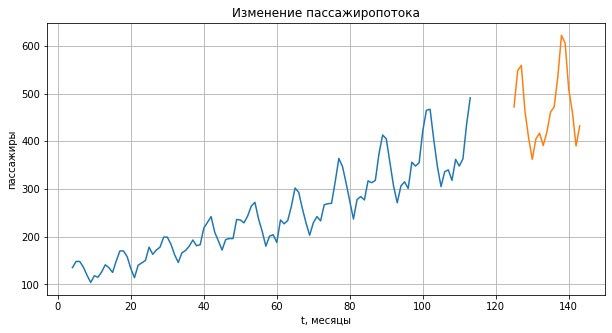

In [149]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(df.index[y_train.shape[0]+x_len+bias+future:],y_val[:])
plt.grid('on')
plt.xlabel('t, месяцы')
plt.ylabel('пассажиры')
plt.title('Изменение пассажиропотока')
plt.show()

## Преобразуем историю в нужный формат

In [12]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
) 

In [14]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (10, 4, 4)
tf.Tensor(
[[-1.54713187 -1.26487074 -2.85773803 -1.30815427]
 [-1.54713187 -0.97799284  0.68757607 -1.30815427]
 [-1.54713187 -0.69111494 -0.4941953  -0.41990137]
 [-1.54713187 -0.40423704  0.68757607 -0.41990137]], shape=(4, 4), dtype=float64)
Target shape: (10,)
tf.Tensor(148, shape=(), dtype=int64)


## Построим простую RNN-сеть

In [152]:
tf.random.set_seed(8)

model = Sequential([
            SimpleRNN(16, activation='relu',
                      input_shape=(4, 4)),
            Dense(1, activation='linear'),

            ])

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
     
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_11 (SimpleRNN)   (None, 16)                336       
                                                                 
 dense_22 (Dense)            (None, 1)                 17        
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


In [154]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val)

Epoch 1/10
11/11 [==============================] - 1s 25ms/step - loss: 65061.5430 - mae: 240.6896 - val_loss: 234364.4844 - val_mae: 478.1299
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 64972.2383 - mae: 240.5073 - val_loss: 234161.4219 - val_mae: 477.9176
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 64894.1289 - mae: 240.3517 - val_loss: 233948.9219 - val_mae: 477.6976
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 64817.9609 - mae: 240.2022 - val_loss: 233723.3906 - val_mae: 477.4665
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 64740.0664 - mae: 240.0497 - val_loss: 233485.3125 - val_mae: 477.2219
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 64662.2227 - mae: 239.8979 - val_loss: 233235.9062 - val_mae: 476.9627
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 64580.1406 - mae: 239.7387 - val_loss: 232968.0156 - val_mae: 47

Увеличим количество скрытых состояний (до 64)

In [155]:
tf.random.set_seed(8)

model = Sequential([
            SimpleRNN(64, activation='relu',
                      input_shape=(4, 4)),
            Dense(1, activation='linear'),

            ])

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
     
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_13 (SimpleRNN)   (None, 64)                4416      
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


In [156]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val)

Epoch 1/10
11/11 [==============================] - 1s 23ms/step - loss: 64508.9531 - mae: 239.5832 - val_loss: 232716.5469 - val_mae: 476.3820
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 63894.8125 - mae: 238.3247 - val_loss: 230796.3125 - val_mae: 474.3145
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 62605.2188 - mae: 235.7682 - val_loss: 226354.6562 - val_mae: 469.4933
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 59413.2227 - mae: 229.4302 - val_loss: 214942.7656 - val_mae: 456.9895
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 51887.2852 - mae: 213.7313 - val_loss: 188266.7188 - val_mae: 426.4771
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 36896.7461 - mae: 177.9693 - val_loss: 136040.9688 - val_mae: 359.2310
Epoch 7/10
11/11 [==============================] - 0s 11ms/step - loss: 15725.8877 - mae: 106.8206 - val_loss: 61444.6172 - val_mae: 23

Еще увеличим количетво скрытых состояний (до 128)

In [158]:
tf.random.set_seed(8)

model = Sequential([
            SimpleRNN(128, activation='relu',
                      input_shape=(4, 4)),
            Dense(1, activation='linear'),

            ])

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
     
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_14 (SimpleRNN)   (None, 128)               17024     
                                                                 
 dense_25 (Dense)            (None, 1)                 129       
                                                                 
Total params: 17,153
Trainable params: 17,153
Non-trainable params: 0
_________________________________________________________________


In [159]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val)

Epoch 1/10
11/11 [==============================] - 1s 23ms/step - loss: 64481.1875 - mae: 239.5781 - val_loss: 232148.7812 - val_mae: 475.7625
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 63200.1875 - mae: 237.0954 - val_loss: 226500.5625 - val_mae: 469.8094
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 58684.4922 - mae: 228.5799 - val_loss: 205256.4062 - val_mae: 446.7591
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 42446.9922 - mae: 194.3132 - val_loss: 135789.0938 - val_mae: 361.4969
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 10941.7861 - mae: 88.2420 - val_loss: 23072.9551 - val_mae: 133.9549
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 11697.6719 - mae: 85.0287 - val_loss: 9872.1523 - val_mae: 81.4442
Epoch 7/10
11/11 [==============================] - 0s 11ms/step - loss: 5803.8481 - mae: 62.7089 - val_loss: 6321.8037 - val_mae: 64.2224
Epoc

## Вывод

На данной задаче увеличение количества скрытых состояний простой RNN-сети ведет к увеличению качества предсказания

## Далее попробует LSTM

In [161]:
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D, Flatten

tf.random.set_seed(8)

model = Sequential()

model.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 4, 32)             4736      
                                                                 
 dense_27 (Dense)            (None, 4, 1)              33        
                                                                 
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [162]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val)

Epoch 1/10
11/11 [==============================] - 2s 50ms/step - loss: 64796.1211 - mae: 240.0696 - val_loss: 234159.0938 - val_mae: 477.9297
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 64748.8906 - mae: 239.9686 - val_loss: 234033.0938 - val_mae: 477.7981
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 64705.3477 - mae: 239.8843 - val_loss: 233896.5312 - val_mae: 477.6554
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 64657.0391 - mae: 239.7908 - val_loss: 233748.9375 - val_mae: 477.5012
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 64599.7773 - mae: 239.6790 - val_loss: 233583.1562 - val_mae: 477.3279
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 64528.1094 - mae: 239.5379 - val_loss: 233388.3906 - val_mae: 477.1240
Epoch 7/10
11/11 [==============================] - 0s 11ms/step - loss: 64434.3359 - mae: 239.3521 - val_loss: 233149.5469 - val_mae: 4

Увеличим количество скрытых состояний (до 128)

In [163]:
tf.random.set_seed(8)

model = Sequential()

model.add(LSTM(128, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 4, 128)            68096     
                                                                 
 dense_28 (Dense)            (None, 4, 1)              129       
                                                                 
Total params: 68,225
Trainable params: 68,225
Non-trainable params: 0
_________________________________________________________________


In [164]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val)

Epoch 1/10
11/11 [==============================] - 2s 52ms/step - loss: 64809.9141 - mae: 240.1065 - val_loss: 234234.3125 - val_mae: 478.0041
Epoch 2/10
11/11 [==============================] - 0s 13ms/step - loss: 64720.9023 - mae: 239.9183 - val_loss: 233954.0156 - val_mae: 477.7108
Epoch 3/10
11/11 [==============================] - 0s 13ms/step - loss: 64612.0742 - mae: 239.7193 - val_loss: 233541.4375 - val_mae: 477.2776
Epoch 4/10
11/11 [==============================] - 0s 13ms/step - loss: 64399.9727 - mae: 239.3306 - val_loss: 232791.5000 - val_mae: 476.4867
Epoch 5/10
11/11 [==============================] - 0s 13ms/step - loss: 63901.9258 - mae: 238.4035 - val_loss: 231235.4375 - val_mae: 474.8400
Epoch 6/10
11/11 [==============================] - 0s 13ms/step - loss: 62907.8359 - mae: 236.4655 - val_loss: 228560.7500 - val_mae: 471.9969
Epoch 7/10
11/11 [==============================] - 0s 13ms/step - loss: 61521.5039 - mae: 233.6100 - val_loss: 225249.4531 - val_mae: 4

Увеличим количество скрытых состояний (до 512)

In [165]:
tf.random.set_seed(8)

model = Sequential()

model.add(LSTM(512, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 4, 512)            1058816   
                                                                 
 dense_29 (Dense)            (None, 4, 1)              513       
                                                                 
Total params: 1,059,329
Trainable params: 1,059,329
Non-trainable params: 0
_________________________________________________________________


In [166]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val)

Epoch 1/10
11/11 [==============================] - 3s 82ms/step - loss: 64857.4297 - mae: 240.1531 - val_loss: 234624.3125 - val_mae: 478.4128
Epoch 2/10
11/11 [==============================] - 0s 42ms/step - loss: 64622.9531 - mae: 239.6597 - val_loss: 233894.7188 - val_mae: 477.6501
Epoch 3/10
11/11 [==============================] - 0s 42ms/step - loss: 63701.7227 - mae: 237.9802 - val_loss: 230232.0625 - val_mae: 473.7881
Epoch 4/10
11/11 [==============================] - 0s 43ms/step - loss: 59744.8984 - mae: 229.8133 - val_loss: 219933.7031 - val_mae: 462.5852
Epoch 5/10
11/11 [==============================] - 0s 43ms/step - loss: 55677.6875 - mae: 220.3544 - val_loss: 211628.5625 - val_mae: 453.3230
Epoch 6/10
11/11 [==============================] - 0s 43ms/step - loss: 52719.8008 - mae: 213.0971 - val_loss: 205475.3125 - val_mae: 446.3298
Epoch 7/10
11/11 [==============================] - 0s 43ms/step - loss: 50296.3750 - mae: 207.0038 - val_loss: 199918.6250 - val_mae: 4

Добавим второй слой LSTM

In [167]:
tf.random.set_seed(8)

model = Sequential()

model.add(LSTM(512, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model.add(LSTM(256, return_sequences=True))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 4, 512)            1058816   
                                                                 
 lstm_32 (LSTM)              (None, 4, 256)            787456    
                                                                 
 dense_30 (Dense)            (None, 4, 1)              257       
                                                                 
Total params: 1,846,529
Trainable params: 1,846,529
Non-trainable params: 0
_________________________________________________________________


In [168]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val)

Epoch 1/10
11/11 [==============================] - 4s 132ms/step - loss: 64884.3281 - mae: 240.1895 - val_loss: 234748.4219 - val_mae: 478.5399
Epoch 2/10
11/11 [==============================] - 1s 67ms/step - loss: 64498.0000 - mae: 239.3398 - val_loss: 234345.4062 - val_mae: 478.1136
Epoch 3/10
11/11 [==============================] - 1s 65ms/step - loss: 61418.6406 - mae: 232.9306 - val_loss: 228761.3438 - val_mae: 472.1893
Epoch 4/10
11/11 [==============================] - 1s 65ms/step - loss: 57723.2148 - mae: 224.8261 - val_loss: 219025.4531 - val_mae: 461.7018
Epoch 5/10
11/11 [==============================] - 1s 65ms/step - loss: 55416.7148 - mae: 219.6543 - val_loss: 213878.5000 - val_mae: 456.0720
Epoch 6/10
11/11 [==============================] - 1s 65ms/step - loss: 53659.5977 - mae: 215.5823 - val_loss: 210082.5938 - val_mae: 451.8620
Epoch 7/10
11/11 [==============================] - 1s 66ms/step - loss: 52172.2344 - mae: 212.0662 - val_loss: 206877.5156 - val_mae: 

Попробуем использовать Bidirectional LSTM

In [169]:
tf.random.set_seed(8)

model = Sequential()

model.add(LSTM(512, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 4, 512)            1058816   
                                                                 
 bidirectional_14 (Bidirecti  (None, 4, 512)           1574912   
 onal)                                                           
                                                                 
 dense_31 (Dense)            (None, 4, 1)              513       
                                                                 
Total params: 2,634,241
Trainable params: 2,634,241
Non-trainable params: 0
_________________________________________________________________


In [170]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val)

Epoch 1/10
11/11 [==============================] - 7s 192ms/step - loss: 64942.2578 - mae: 240.2610 - val_loss: 235056.7656 - val_mae: 478.8582
Epoch 2/10
11/11 [==============================] - 1s 90ms/step - loss: 64036.9258 - mae: 238.4968 - val_loss: 233523.2344 - val_mae: 477.1725
Epoch 3/10
11/11 [==============================] - 1s 90ms/step - loss: 58343.2656 - mae: 226.2266 - val_loss: 225922.2500 - val_mae: 468.9458
Epoch 4/10
11/11 [==============================] - 1s 89ms/step - loss: 51895.2305 - mae: 212.1855 - val_loss: 204655.6875 - val_mae: 445.9073
Epoch 5/10
11/11 [==============================] - 1s 89ms/step - loss: 47656.3047 - mae: 201.7319 - val_loss: 196118.1875 - val_mae: 436.2430
Epoch 6/10
11/11 [==============================] - 1s 89ms/step - loss: 44747.8008 - mae: 194.3212 - val_loss: 189705.9688 - val_mae: 428.8074
Epoch 7/10
11/11 [==============================] - 1s 90ms/step - loss: 42248.7461 - mae: 187.7109 - val_loss: 184204.3750 - val_mae: 

Добавим еще один слой

In [171]:
tf.random.set_seed(8)

model = Sequential()

model.add(LSTM(512, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 4, 512)            1058816   
                                                                 
 bidirectional_15 (Bidirecti  (None, 4, 512)           1574912   
 onal)                                                           
                                                                 
 bidirectional_16 (Bidirecti  (None, 4, 256)           656384    
 onal)                                                           
                                                                 
 dense_32 (Dense)            (None, 4, 1)              257       
                                                                 
Total params: 3,290,369
Trainable params: 3,290,369
Non-trainable params: 0
_________________________________________________________________


In [172]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val)

Epoch 1/10
11/11 [==============================] - 10s 255ms/step - loss: 64926.9258 - mae: 240.2471 - val_loss: 234687.4844 - val_mae: 478.4746
Epoch 2/10
11/11 [==============================] - 1s 99ms/step - loss: 62827.6016 - mae: 236.4364 - val_loss: 230739.4531 - val_mae: 474.1321
Epoch 3/10
11/11 [==============================] - 1s 98ms/step - loss: 58142.3398 - mae: 225.4645 - val_loss: 226823.1562 - val_mae: 469.9667
Epoch 4/10
11/11 [==============================] - 1s 102ms/step - loss: 54690.9375 - mae: 218.2780 - val_loss: 214905.0625 - val_mae: 456.9585
Epoch 5/10
11/11 [==============================] - 1s 101ms/step - loss: 52205.8477 - mae: 212.5810 - val_loss: 206878.5000 - val_mae: 448.4768
Epoch 6/10
11/11 [==============================] - 1s 102ms/step - loss: 50794.3281 - mae: 209.2199 - val_loss: 203946.8438 - val_mae: 445.1957
Epoch 7/10
11/11 [==============================] - 1s 102ms/step - loss: 49469.0312 - mae: 206.0096 - val_loss: 201182.5625 - val_

Вернем к предыдущей версии сети, но увеличим количество эпох до 25

In [173]:
tf.random.set_seed(8)

model = Sequential()

model.add(LSTM(512, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 4, 512)            1058816   
                                                                 
 bidirectional_17 (Bidirecti  (None, 4, 512)           1574912   
 onal)                                                           
                                                                 
 dense_33 (Dense)            (None, 4, 1)              513       
                                                                 
Total params: 2,634,241
Trainable params: 2,634,241
Non-trainable params: 0
_________________________________________________________________


In [174]:
history = model.fit(dataset_train,
                    epochs=25,
                    validation_data=dataset_val)

Epoch 1/25
11/11 [==============================] - 6s 187ms/step - loss: 64942.2578 - mae: 240.2610 - val_loss: 235056.7656 - val_mae: 478.8582
Epoch 2/25
11/11 [==============================] - 1s 90ms/step - loss: 64036.9258 - mae: 238.4968 - val_loss: 233523.2344 - val_mae: 477.1725
Epoch 3/25
11/11 [==============================] - 1s 92ms/step - loss: 58343.2656 - mae: 226.2266 - val_loss: 225922.2500 - val_mae: 468.9458
Epoch 4/25
11/11 [==============================] - 1s 89ms/step - loss: 51895.2305 - mae: 212.1855 - val_loss: 204655.6875 - val_mae: 445.9073
Epoch 5/25
11/11 [==============================] - 1s 91ms/step - loss: 47656.3047 - mae: 201.7319 - val_loss: 196118.1875 - val_mae: 436.2430
Epoch 6/25
11/11 [==============================] - 1s 91ms/step - loss: 44747.8008 - mae: 194.3212 - val_loss: 189705.9688 - val_mae: 428.8074
Epoch 7/25
11/11 [==============================] - 1s 91ms/step - loss: 42248.7461 - mae: 187.7109 - val_loss: 184204.3750 - val_mae: 

## Вывод

- увеличение количества скрытых состояний улучшает перформанс
- дополнительный слой bidirectional улучшил модель
- даже после увеличения количества эпох до 25 модель продолжала обучаться и улучшаться
- не могу понять, почему для данной задачи метрика LSTM оказалась хуже метрик, полученных с помощью RNN

## Для эксперимента сделаем глубокую сеть с конолюционными слоями

In [18]:
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D, Flatten

tf.random.set_seed(8)

early_stop = EarlyStopping(monitor='val_mae', patience=5)


model = Sequential()

model.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(Conv1D(64, 3, activation='linear'))
model.add(Conv1D(64, 1, activation='linear'))
model.add(Flatten())
model.add(Dense(3, activation='linear'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 4, 32)             4736      
                                                                 
 lstm_3 (LSTM)               (None, 4, 32)             8320      
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 64)             6208      
                                                                 
 conv1d_3 (Conv1D)           (None, 2, 64)             4160      
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
 dense_3 (Dense)             (None, 1)                

In [19]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
11/11 [==============================] - 5s 118ms/step - loss: 64765.9688 - mae: 240.0212 - val_loss: 234064.7812 - val_mae: 477.8348
Epoch 2/10
11/11 [==============================] - 0s 18ms/step - loss: 64377.6445 - mae: 239.2484 - val_loss: 232785.6875 - val_mae: 476.5135
Epoch 3/10
11/11 [==============================] - 0s 18ms/step - loss: 63195.1211 - mae: 237.0269 - val_loss: 228115.3750 - val_mae: 471.6679
Epoch 4/10
11/11 [==============================] - 0s 19ms/step - loss: 58879.8516 - mae: 228.7946 - val_loss: 210660.0938 - val_mae: 453.0964
Epoch 5/10
11/11 [==============================] - 0s 19ms/step - loss: 44552.6445 - mae: 199.0326 - val_loss: 154130.5781 - val_mae: 386.7558
Epoch 6/10
11/11 [==============================] - 0s 18ms/step - loss: 12110.4131 - mae: 101.5785 - val_loss: 39222.8203 - val_mae: 189.7104
Epoch 7/10
11/11 [==============================] - 0s 20ms/step - loss: 5622.6499 - mae: 61.7628 - val_loss: 10819.8867 - val_mae: 89.9

## Далее попробует GRU

In [21]:
from keras.layers import GRU

model = Sequential()

model.add(GRU(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 4, 32)             3648      
                                                                 
 dense_4 (Dense)             (None, 4, 1)              33        
                                                                 
Total params: 3,681
Trainable params: 3,681
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val)

Epoch 1/10
11/11 [==============================] - 3s 60ms/step - loss: 64794.1602 - mae: 240.1222 - val_loss: 233785.7500 - val_mae: 477.5453
Epoch 2/10
11/11 [==============================] - 0s 17ms/step - loss: 64726.9141 - mae: 239.9810 - val_loss: 233603.4375 - val_mae: 477.3542
Epoch 3/10
11/11 [==============================] - 0s 15ms/step - loss: 64665.2305 - mae: 239.8663 - val_loss: 233395.2344 - val_mae: 477.1361
Epoch 4/10
11/11 [==============================] - 0s 15ms/step - loss: 64597.4531 - mae: 239.7415 - val_loss: 233161.9531 - val_mae: 476.8917
Epoch 5/10
11/11 [==============================] - 0s 14ms/step - loss: 64518.3750 - mae: 239.5956 - val_loss: 232891.7031 - val_mae: 476.6085
Epoch 6/10
11/11 [==============================] - 0s 16ms/step - loss: 64420.6250 - mae: 239.4145 - val_loss: 232563.5469 - val_mae: 476.2643
Epoch 7/10
11/11 [==============================] - 0s 14ms/step - loss: 64292.4922 - mae: 239.1763 - val_loss: 232144.2969 - val_mae: 4

Увеличим количество скрытых состояний до 128

In [23]:
from keras.layers import GRU

model = Sequential()

model.add(GRU(128, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 4, 128)            51456     
                                                                 
 dense_5 (Dense)             (None, 4, 1)              129       
                                                                 
Total params: 51,585
Trainable params: 51,585
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val)

Epoch 1/10
11/11 [==============================] - 4s 65ms/step - loss: 64816.1484 - mae: 240.0974 - val_loss: 234413.1406 - val_mae: 478.1903
Epoch 2/10
11/11 [==============================] - 0s 18ms/step - loss: 64656.3828 - mae: 239.7594 - val_loss: 233972.6250 - val_mae: 477.7289
Epoch 3/10
11/11 [==============================] - 0s 18ms/step - loss: 64465.3281 - mae: 239.4045 - val_loss: 233340.9688 - val_mae: 477.0663
Epoch 4/10
11/11 [==============================] - 0s 16ms/step - loss: 64094.0078 - mae: 238.7107 - val_loss: 232144.0625 - val_mae: 475.8054
Epoch 5/10
11/11 [==============================] - 0s 17ms/step - loss: 63096.8125 - mae: 236.8302 - val_loss: 229066.7812 - val_mae: 472.5348
Epoch 6/10
11/11 [==============================] - 0s 18ms/step - loss: 61149.9102 - mae: 232.8112 - val_loss: 224713.2188 - val_mae: 467.8790
Epoch 7/10
11/11 [==============================] - 0s 19ms/step - loss: 59399.9727 - mae: 228.8497 - val_loss: 221537.7500 - val_mae: 4

Увеличим количество скрытых состояний до 512

In [25]:
from keras.layers import GRU

model = Sequential()

model.add(GRU(512, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 4, 512)            795648    
                                                                 
 dense_6 (Dense)             (None, 4, 1)              513       
                                                                 
Total params: 796,161
Trainable params: 796,161
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val)

Epoch 1/10
11/11 [==============================] - 4s 93ms/step - loss: 64857.8008 - mae: 240.1364 - val_loss: 234885.7656 - val_mae: 478.6814
Epoch 2/10
11/11 [==============================] - 0s 41ms/step - loss: 64317.1094 - mae: 239.0298 - val_loss: 233353.2812 - val_mae: 477.0724
Epoch 3/10
11/11 [==============================] - 0s 40ms/step - loss: 60944.7617 - mae: 232.6082 - val_loss: 222405.9844 - val_mae: 465.2611
Epoch 4/10
11/11 [==============================] - 0s 45ms/step - loss: 55323.2461 - mae: 219.6581 - val_loss: 211199.1250 - val_mae: 452.8870
Epoch 5/10
11/11 [==============================] - 1s 56ms/step - loss: 52153.2227 - mae: 211.8920 - val_loss: 204556.7656 - val_mae: 445.4112
Epoch 6/10
11/11 [==============================] - 1s 60ms/step - loss: 49368.1680 - mae: 205.1133 - val_loss: 197982.6875 - val_mae: 437.8731
Epoch 7/10
11/11 [==============================] - 1s 64ms/step - loss: 46570.3906 - mae: 198.0466 - val_loss: 191539.5938 - val_mae: 4

Добавим второй слой

In [27]:
from keras.layers import GRU

model = Sequential()

model.add(GRU(512, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model.add(GRU(256, return_sequences=True))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 4, 512)            795648    
                                                                 
 gru_4 (GRU)                 (None, 4, 256)            591360    
                                                                 
 dense_7 (Dense)             (None, 4, 1)              257       
                                                                 
Total params: 1,387,265
Trainable params: 1,387,265
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val)

Epoch 1/10
11/11 [==============================] - 8s 151ms/step - loss: 65022.2148 - mae: 240.3382 - val_loss: 236063.0312 - val_mae: 479.8997
Epoch 2/10
11/11 [==============================] - 1s 64ms/step - loss: 63652.2656 - mae: 237.5500 - val_loss: 233774.5781 - val_mae: 477.4689
Epoch 3/10
11/11 [==============================] - 1s 62ms/step - loss: 58738.8633 - mae: 227.3370 - val_loss: 220440.5156 - val_mae: 463.2355
Epoch 4/10
11/11 [==============================] - 1s 61ms/step - loss: 55601.4844 - mae: 220.2704 - val_loss: 213894.8594 - val_mae: 456.1361
Epoch 5/10
11/11 [==============================] - 1s 58ms/step - loss: 53775.2656 - mae: 216.0438 - val_loss: 210134.0156 - val_mae: 451.9977
Epoch 6/10
11/11 [==============================] - 1s 62ms/step - loss: 52116.7773 - mae: 212.1942 - val_loss: 206551.2656 - val_mae: 448.0310
Epoch 7/10
11/11 [==============================] - 1s 60ms/step - loss: 50405.1367 - mae: 208.1942 - val_loss: 202734.0625 - val_mae: 

Добавим еще слой

In [32]:
#from keras.layers import Dropout

model = Sequential()

model.add(GRU(512, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model.add(GRU(256, return_sequences=True))
model.add(GRU(64, return_sequences=True))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_11 (GRU)                (None, 4, 512)            795648    
                                                                 
 gru_12 (GRU)                (None, 4, 256)            591360    
                                                                 
 gru_13 (GRU)                (None, 4, 64)             61824     
                                                                 
 dense_9 (Dense)             (None, 4, 1)              65        
                                                                 
Total params: 1,448,897
Trainable params: 1,448,897
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val)

Epoch 1/10
11/11 [==============================] - 7s 180ms/step - loss: 64996.5156 - mae: 240.2856 - val_loss: 235776.1094 - val_mae: 479.6058
Epoch 2/10
11/11 [==============================] - 1s 55ms/step - loss: 63526.3594 - mae: 237.3010 - val_loss: 233148.4844 - val_mae: 476.8345
Epoch 3/10
11/11 [==============================] - 1s 55ms/step - loss: 60962.1367 - mae: 232.0623 - val_loss: 225885.0938 - val_mae: 469.1746
Epoch 4/10
11/11 [==============================] - 1s 82ms/step - loss: 60009.4727 - mae: 230.0042 - val_loss: 223963.8125 - val_mae: 467.1348
Epoch 5/10
11/11 [==============================] - 1s 94ms/step - loss: 59243.6992 - mae: 228.3396 - val_loss: 222420.2500 - val_mae: 465.4839
Epoch 6/10
11/11 [==============================] - 1s 101ms/step - loss: 58652.1875 - mae: 227.0218 - val_loss: 221302.0781 - val_mae: 464.2819
Epoch 7/10
11/11 [==============================] - 1s 90ms/step - loss: 58202.2070 - mae: 226.0169 - val_loss: 220424.9375 - val_mae:

Изменим подход и попробуем в каждом слое увеличивать количество скрытых состояний

In [34]:
model = Sequential()

model.add(GRU(64, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model.add(GRU(256, return_sequences=True))
model.add(GRU(512, return_sequences=True))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_14 (GRU)                (None, 4, 64)             13440     
                                                                 
 gru_15 (GRU)                (None, 4, 256)            247296    
                                                                 
 gru_16 (GRU)                (None, 4, 512)            1182720   
                                                                 
 dense_10 (Dense)            (None, 4, 1)              513       
                                                                 
Total params: 1,443,969
Trainable params: 1,443,969
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val)

Epoch 1/10
11/11 [==============================] - 9s 196ms/step - loss: 64897.7188 - mae: 240.1691 - val_loss: 234995.1562 - val_mae: 478.7939
Epoch 2/10
11/11 [==============================] - 1s 73ms/step - loss: 61492.6758 - mae: 233.8369 - val_loss: 221609.7656 - val_mae: 464.4402
Epoch 3/10
11/11 [==============================] - 1s 69ms/step - loss: 54281.5039 - mae: 217.5032 - val_loss: 207726.4062 - val_mae: 449.1924
Epoch 4/10
11/11 [==============================] - 1s 71ms/step - loss: 50186.1016 - mae: 207.8032 - val_loss: 200030.7344 - val_mae: 440.4840
Epoch 5/10
11/11 [==============================] - 1s 75ms/step - loss: 47193.2891 - mae: 200.1521 - val_loss: 193894.8438 - val_mae: 433.4592
Epoch 6/10
11/11 [==============================] - 1s 70ms/step - loss: 44479.4102 - mae: 193.2678 - val_loss: 187475.7656 - val_mae: 426.0421
Epoch 7/10
11/11 [==============================] - 1s 64ms/step - loss: 41528.5430 - mae: 185.7892 - val_loss: 180053.9531 - val_mae: 

## Выводы

- В этой задаче GRU показал себя хуже остальных (почему так?)
- увеличение количества скрытых состояний улучшало результат
- увеличение до 2 слоев GRU улучшило перформанс, до 3-х - уже ухудшило
- подход увеличения скрытых состояний на каждом новом слое улучшил метрики
